### Using fluent methods to add descriptions

First add this package   
  
`dotnet add package Microsoft.AspNetCore.OpenApi`  
  
Now you can add some metadata `With*` methods, like `WithName()`, `WithTags()`, `WithSummary()` and `WithDescription()`.

In [ ]:
using System.Collections.Concurrent;

WebApplicationBuilder builder = WebApplication.CreateBuilder(args);

builder.Services.AddEndpointsApiExplorer();

builder.Services.AddSwaggerGen();

WebApplication app = builder.Build();

app.UseSwagger();
app.UseSwaggerUI();

var _fruit = new ConcurrentDictionary<string, Fruit>();

app.MapGet("/fruit/{id}", (string id) =>
    _fruit.TryGetValue(id, out var fruit)
        ? TypedResults.Ok(fruit)
    : Results.Problem(statusCode: 404))
    .WithName("GetFruit")
    .WithTags("fruit")
    .Produces<Fruit>()
    .ProducesProblem(404)
    .WithSummary("Fetches a fruit")
    .WithDescription("Fetches a fruit by id, or returns 404" +
        " if no fruit with the ID exists")
    .WithOpenApi();

app.Run();
record Fruit(string Name, int Stock);

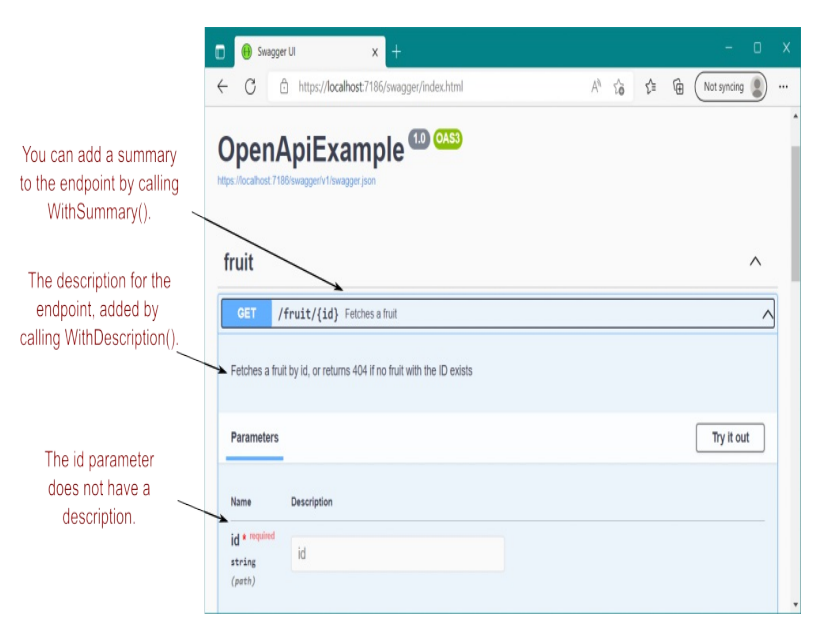

if you want to **add description** to `parameter` you can use following code 

In [ ]:
.WithOpenApi(o =>
{
    o.Parameters[0].Description = "The id of the fruit to fetch";
    o.Summary = "Fetches a fruit";
    return o;
});

### Using attributes to add metadata

In [ ]:
using Microsoft.AspNetCore.Mvc;
using System.Collections.Concurrent;

WebApplicationBuilder builder = WebApplication.CreateBuilder(args);

builder.Services.AddEndpointsApiExplorer();

builder.Services.AddSwaggerGen();

WebApplication app = builder.Build();

app.UseSwagger();
app.UseSwaggerUI();

var _fruit = new ConcurrentDictionary<string, Fruit>();

app.MapGet("/fruit/{id}",
    [EndpointName("GetFruit")]
    [EndpointSummary("Fetches a fruit")]
    [EndpointDescription("Fetches a fruit by id, or returns 404" +
            " if no fruit with the ID exists")]
    [ProducesResponseType(typeof(Fruit), 200)]
    [ProducesResponseType(typeof(HttpValidationProblemDetails), 404,
            "application/problem+json")]
    [Tags("fruit")]
    (string id) =>
        _fruit.TryGetValue(id, out var fruit)
            ? TypedResults.Ok(fruit)
            : Results.Problem(statusCode: 404))
        .WithOpenApi(o =>
        {
            o.Parameters[0].Description = "The id of the fruit to fetch";
            return o;
        });

app.Run();
record Fruit(string Name, int Stock);

### Using XML documentation comments to add metadata

The use of ***XML documentation comments*** is only partially supported in `.NET 7`. These comments work only when you have `static` or `instance method`
***endpoint handlers***, `not lambda methods or local functions`.

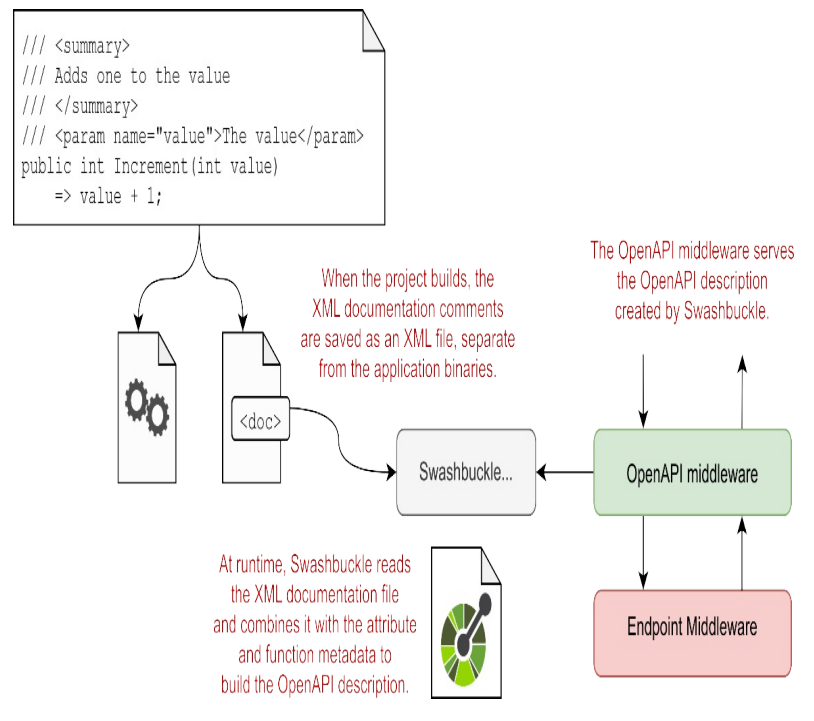

To `enable` XML documentation you must do three things

`1.` Enable documentation generation for your project. Add the
`<GenerateDocumentationFile>` inside a `<PropertyGroup>` in your
csproj file, and set it to true:

In [ ]:
<PropertyGroup>
    <GenerateDocumentationFile>true</GenerateDocumentationFile>
</PropertyGroup>

`2.` Configure Swashbuckle to read the generated XML document in `SwaggerGen()`:

In [ ]:
builder.Services.AddSwaggerGen(opts =>
{
    var file = $"{Assembly.GetExecutingAssembly().GetName().Name}.xml";
    opts.IncludeXmlComments(Path.Combine(AppContext.BaseDirectory, file));
});

`3.` Use a **static** or **instance method** handler and add the XML comments, as
shown in the following listing.

In [ ]:
using Microsoft.AspNetCore.Mvc;
using System.Collections.Concurrent;
using System.Reflection;

WebApplicationBuilder builder = WebApplication.CreateBuilder(args);

builder.Services.AddEndpointsApiExplorer();

builder.Services.AddSwaggerGen(opts =>
{
    var file = $"{Assembly.GetExecutingAssembly().GetName().Name}.xml";
    opts.IncludeXmlComments(Path.Combine(AppContext.BaseDirectory, file));
});

WebApplication app = builder.Build();
app.UseSwagger();
app.UseSwaggerUI();
var _fruit = new ConcurrentDictionary<string, Fruit>();

var handler = new FruitHandler(_fruit);

app.MapGet("/fruit/{id}", handler.GetFruit)
.WithName("GetFruit");
app.Run();
record Fruit(string Name, int Stock);

internal class FruitHandler
{
    private readonly ConcurrentDictionary<string, Fruit> _fruit;

    public FruitHandler(ConcurrentDictionary<string, Fruit> fruit)
    {
        _fruit = fruit;
    }

    /// <summary>
    /// Fetches a fruit by id, or returns 404 if it does not exist
    /// </summary>
    /// <param name="id" >The ID of the fruit to fetch</param>
    /// <response code="200">Returns the fruit if it exists</response>
    /// <response code="404">If the fruit doesn't exist</response>
    [ProducesResponseType(typeof(Fruit), 200)]
    [ProducesResponseType(typeof(HttpValidationProblemDetails),
        404, "application/problem+json")]
    [Tags("fruit")]
    public IResult GetFruit(string id)
        => _fruit.TryGetValue(id, out var fruit)
            ? TypedResults.Ok(fruit)
            : Results.Problem(statusCode: 404);
}